[1.0, 0.96875, 0.967741935483871, 0.9666666666666667, 0.9655172413793104, 0.9642857142857143, 0.9629629629629629, 0.9615384615384616, 0.96, 0.9583333333333334, 0.9565217391304348, 0.9545454545454546, 0.9523809523809523, 0.95, 0.9473684210526315, 0.9444444444444444, 0.9411764705882353, 0.9375, 0.9333333333333333, 0.9285714285714286, 0.9230769230769231, 0.9166666666666666, 0.9090909090909091, 0.9, 0.8888888888888888, 0.875, 0.9142857142857144, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 0.9990234375, 0.9970674486803519, 0.9950980392156863, 0.993103448275862, 0.9910714285714286, 0.988988988988989, 0.9868421052631579, 0.9846153846153847, 0.9822916666666667, 0.9798515376458112, 0.9772727272727273, 0.9745293466223699, 0.9715909090909091, 0.968421052631579, 0.964975845410628, 0.9612015018773467, 0.95703125, 0.9523809523809523, 0.9471428571428572, 0.9411764705882353, 0.9342948717948718, 0.9262435677530018, 0.9166666666666666, 0.9050505050505051, 0.890625, 0.8721804511278195, 0.8477011494252874, 0.813559322

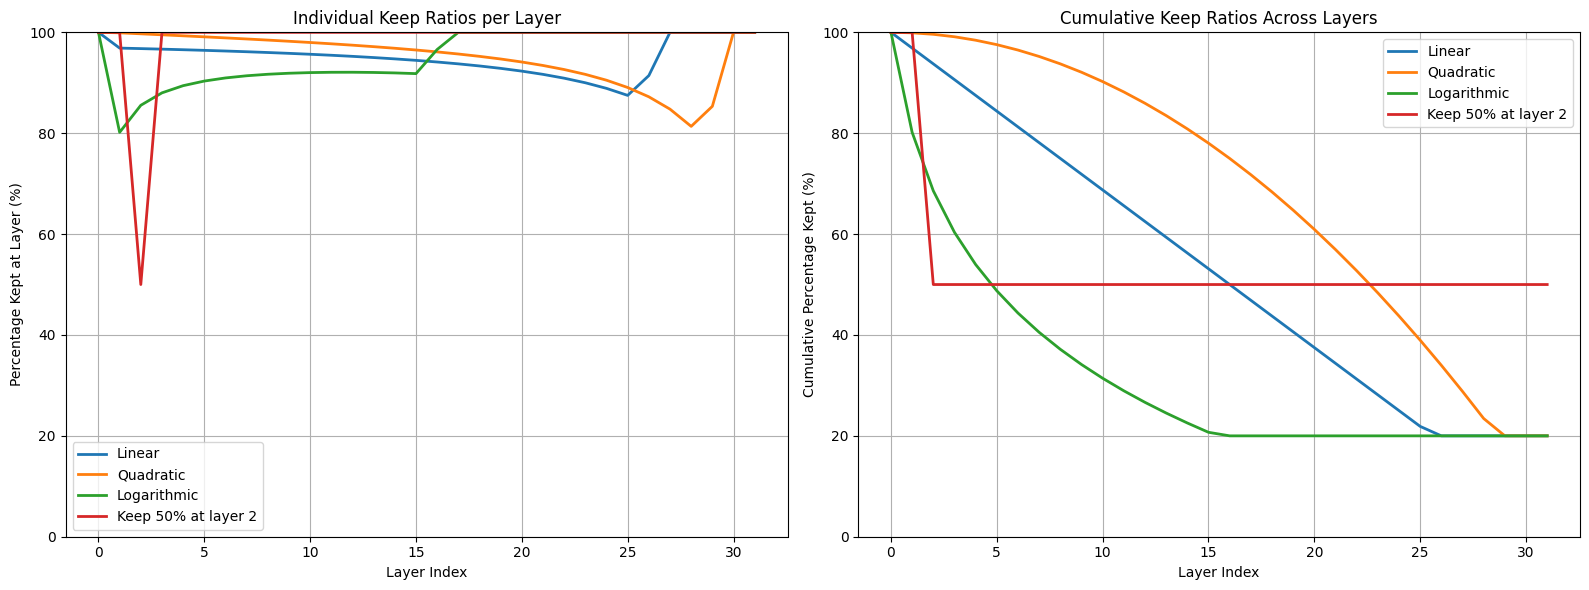

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def _calc_cumulative_keep_ratio(f, layer_idx: int, K: int=0, min_keep_ratio: float = 0):
    """Calculate cumulative keep ratio at a given layer."""
    layer_idx = layer_idx - K
    if layer_idx < 0:
        return 1.0
    layer_prune_ratio = f(layer_idx)
    cumulative_layer_keep_ratio = 1 - layer_prune_ratio
    return max(cumulative_layer_keep_ratio, min_keep_ratio)

def _calc_individual_keep_ratios(f, total_layers, K=0, min_keep_ratio=0):
    """Calculate individual keep ratios from cumulative ratios."""
    individual_keep = []
    prev_cumulative = 1.0
    
    for layer in range(total_layers):
        current_cumulative = _calc_cumulative_keep_ratio(f, layer, K, min_keep_ratio)
        r_k = current_cumulative / prev_cumulative if prev_cumulative > 0 else 0.0
        r_k = max(r_k, min_keep_ratio)
        individual_keep.append(r_k)
        prev_cumulative = current_cumulative
    
    return individual_keep

# Fixed pruning strategy functions
def linear(x, T): return x / T
def quadratic(x, T): return (x ** 2) / (T ** 2)
def logarithmic(x, T): return np.log(x + 1) / np.log(T + 1)
def keep_r_at_k(x, r, k, T): return 0 if x < k else (1 - r)  # Returns prune ratio

# Parameters
total_layers = 32
layers = np.arange(total_layers)
min_keep_ratio = 0.2

strategies = {
    "Linear": lambda x: linear(x, total_layers),
    "Quadratic": lambda x: quadratic(x, total_layers),
    "Logarithmic": lambda x: logarithmic(x, total_layers),
    "Keep 50% at layer 2": lambda x: keep_r_at_k(x, 0.5, 2, total_layers),
}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot individual keep ratios
for name, strategy in strategies.items():
    individual_ratios = _calc_individual_keep_ratios(strategy, total_layers, min_keep_ratio=min_keep_ratio)
    ax1.plot(layers, [r * 100 for r in individual_ratios], label=name, linewidth=2)

ax1.set_xlabel('Layer Index')
ax1.set_ylabel('Percentage Kept at Layer (%)')
ax1.set_title('Individual Keep Ratios per Layer')
ax1.legend()
ax1.grid(True)
ax1.set_ylim(0, 100)

# Plot cumulative keep ratios - FIXED VERSION
for name, strategy in strategies.items():
    cumulative_keep = 1.0
    cumulative_ratios = []
    individual_ratios = _calc_individual_keep_ratios(strategy, total_layers, min_keep_ratio=min_keep_ratio)
    print(individual_ratios)
    for r in individual_ratios:
        cumulative_keep *= r
        cumulative_ratios.append(cumulative_keep * 100)
    
    ax2.plot(layers, cumulative_ratios, label=name, linewidth=2)

ax2.set_xlabel('Layer Index')
ax2.set_ylabel('Cumulative Percentage Kept (%)')
ax2.set_title('Cumulative Keep Ratios Across Layers')
ax2.legend()
ax2.grid(True)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

In [ ]:
# calculate flops

# K ... layer were pruning starts
# R ... prune ratio
# T ... num total layers --> 32
# n ... num tokens
# d ... hidden state embedding size --> 1152
# m ... intermediate size of FFN --> 18944
# n_hat ... (1-R)


def calc_flops_for_layer(n: int = 1, d: int = 1152, m: int = 18944):
    return (4 * n * d**2) + (2 * n**2 * d) + (2 * n * d * m)

layers = np.arange(0,32)


flops = {
    "Linear (f(x)=x)": 0,
    "Quadratic (f(x)=x²)": 0,
    "Logarithmic (f(x)=log(x+1))": 0,
    "Keep 0.5 at layer 2": 0
}

for name, func in functions.items():
    n = 100
    for layer in layers:
        cumulative_layer_keep_ratio, _ = _calc_cumulative_keep_ratio(func, layer, K=2, min_keep_ratio=0.0)
        n = n * cumulative_layer_keep_ratio
        flops[name] += calc_flops_for_layer(n)

for name, flops in flops.items():
    print(f"{name}: {"{:.2e}".format(flops)}")


Linear (f(x)=x): 4.31e+10
Quadratic (f(x)=x²): 7.22e+10
Logarithmic (f(x)=log(x+1)): 2.46e+10
Keep 0.5 at layer 2: 1.97e+10


0.6920398436307741